# Exact Quantum Simulation for XY model

## The XY model
The $XY$ model is a generalization of 1D Ising and is also the simplest non-trivial integrable model. When we use exact quantum simulation on the many-body physics model, we will be able to access the states in the whole spectrum rather than only ground states. 

The Hamiltonian of XY model can be written as:
$$H_{XY}=\sum_{i=1}^n(\frac{1+\gamma}{2}\sigma_i^x\sigma_{i+1}^x+\frac{1-\gamma}{2}\sigma_i^y\sigma_{i+1}^y)+\lambda\sum_{i=1}^n\sigma_i^z+\frac{1+\gamma}{2}\sigma_1^y\sigma_2^z...\sigma_{n-1}^z\sigma_n^y+\frac{1-\gamma}{2}\sigma_1^x\sigma_2^z...\sigma_{n-1}^z\sigma_n^x$$

It describes an anisotropic nearest-neighbor spin-spin interaction in $XY$-plane with a external magnetic field $\lambda$ along $z$ direction. The last two terms are introduced to give the correct boundary condition when transform the model to Fermionic basis. They will be surpressed as $n\rightarrow\infty$.

This model can be reduced to two unversality class. For $\gamma = 0$ the model is isotropic in $xy$-plane with central charge $c=1$. For $\gamma = 1$ the model becomes Ising model with central charge $c=1/2$.

## The exact solution and quantum circuit implementation for XY model

The idea of quantum simulation is that we impose the interaction of target quantum system to a set of unentangled qubits and these qubits will simulate the target quantum system. In this notebook, the target quantum system is the XY model, the unentagled qubits sit at the begining of a quantum circuit and we impose the interaction by applying a series of quantum gates.

We want to create a quantum circuit $U_{dis}$ to diagonalize the Hamiltonian such that $$H_{XY} =U_{dis}\tilde{H}U_{dis}^\dagger $$.

Using this circuit, we can 
* start from a eigenstate(product state) of the non-interaction Hamiltonian $\tilde{H}$ to create the excited eigenstates of $H_{XY}$
* simulate time evolution of a state
* simulate thermal state $exp(-\beta H_{XY})$

In [1]:
import tequila as tq
import numpy as np
from numpy import pi
import qiskit

In [2]:
from qiskit import IBMQ
MY_IBMQ_TOKEN="3de053f9144678e01b3b90f616b8d0ffd44af1b3ae5977704ccbf9b650d47b4d4637f37c06eef7658e26efc40d2105e1c5c5fef207b84774c9a5630887fd5063"
IBMQ.save_account(MY_IBMQ_TOKEN, overwrite=True) # needs to be done once, and is then saved in our environment
IBMQ.load_account()
# see the list of backends that you can use:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
print(provider.backends())

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]


In [3]:
tq.show_available_simulators()

backend         | wfn        | sampling   | noise      | installed 
--------------------------------------------------------------------
qulacs_gpu      | False      | False      | False      | False     
qulacs          | True       | True       | True       | True      
qibo            | False      | False      | False      | False     
qiskit          | True       | True       | True       | True      
cirq            | True       | True       | True       | True      
pyquil          | False      | False      | False      | False     
symbolic        | True       | False      | False      | True      


(In Teaqulia we can compile the circuit into object with different backend. )

In [4]:
def fSWAP(q0,q1):
    circuit = tq.gates.CNOT(q0,q1) + tq.gates.CNOT(q1,q0) + tq.gates.CNOT(q0,q1)
    circuit += tq.gates.CZ(q0,q1)
    return circuit
    
    
qiskit_fswap = tq.compile(fSWAP(0,1),backend = 'qiskit')
qiskit_fswap.circuit.draw()

┌───┐        
q_0: ──■──┤ X ├──■───■─
     ┌─┴─┐└─┬─┘┌─┴─┐ │ 
q_1: ┤ X ├──■──┤ X ├─■─
     └───┘     └───┘   
c: 2/══════════════════

In [5]:
# CH (Controlled-Haddamard)
# control qubit: q1
# target qubit: q0
def CH2(q0,q1):
    circuit = tq.gates.Phase(phi=-pi/2,target=q0) + tq.gates.H(q0) + tq.gates.Phase(phi=-pi/4,target=q0)
    circuit += tq.gates.H(q0) + tq.gates.H(q1) + tq.gates.CNOT(q0,q1) + tq.gates.H(q0) +tq.gates.H(q1)
    circuit += tq.gates.T(q0) + tq.gates.H(q0) + tq.gates.S(q0)
    return circuit
qiskit_mix = tq.compile(CH2(0,1),backend = 'qiskit')
# Fourier transform gates

def F2(q0,q1):
    circuit = tq.gates.CNOT(q0,q1) + CH2(q0,q1) + tq.gates.CNOT(q0,q1) +tq.gates.CZ(q0,q1)
    return circuit

def F0(q0,q1):
    return F2(q0,q1)
    
def F1(q0,q1):
    return F2(q0,q1) + tq.gates.Phase(phi=-pi/2,target=q0)


Bogoliubov transformation

In [6]:
from math import pi

# control qubit: q0
# target qubit: q1
def CRX(theta, q0, q1):
    circuit = tq.gates.Rz(angle=pi/2.0,target=q1) + tq.gates.Ry(angle=theta, target=q1) + tq.gates.CNOT(q0,q1)
    circuit += tq.gates.Ry(angle=-pi/2.0,target=q1) + tq.gates.CNOT(q0,q1) + tq.gates.Rz(angle=-pi/2.0,target=q1)
    return circuit

def B(theta_k,q0,q1):
#     circuit = tq.gates.X(q1) + tq.gates.CX(control=q1,target=q0) +CRX(theta_k,q0,q1) + tq.gates.CX(control=q1,target=q0)+tq.gates.X(q1)
    circuit = tq.gates.X(q1) + tq.gates.CX(control=q1,target=q0) +tq.gates.CRx(control=q0,target=q1,angle=theta_k) + tq.gates.CX(control=q1,target=q0)+tq.gates.X(q1)

    return circuit

For XY model, the quantum circuit will depends on another parameter: $\gamma$. Only Bogoliubov transformation will be different.

$$\theta_k=2\arctan(\frac{J\gamma\sin(2\pi k/n)}{J\cos(2\pi k/n)+\lambda})$$

or use PRA convention:

$$\theta_k=\arccos(\frac{-\lambda+\cos(2\pi k/n)}{\sqrt{(\lambda-\cos(2\pi k/n))^2+\gamma^2\sin^2(2\pi k /n)}})$$

where $J=1, k=1,n=4$

In [7]:
def Udisg(lam,gamma,q0,q1,q2,q3):
    k=1
    n=4
#     th1=-np.arccos((lam-np.cos(2*pi*k/n))/np.sqrt((lam-np.cos(2*pi*k/n))**2+np.sin(2*pi*k/n)**2))
#     th1 = 2*np.arctan( (gamma*np.sin( 2*pi*k/n )) / (np.cos( 2*pi*k/n ) + lam ))
    th1 = -np.arccos((lam-np.cos(2*pi*k/n))/np.sqrt((lam-np.cos(2*pi*k/n))**2+gamma**2 * np.sin(2*pi*k/n)**2))
    circuit = B(th1,q0,q1)+ F1(q0,q1) + F0(q2,q3)
    #fSWAP(Udis,q2,q1) # for ibmqx2
    #fSWAP(Udis,q1,q2) # for ibmqx4
    circuit += F0(q0,q2)
    circuit += F0(q1,q3)
    #fSWAP(Udis,q2,q1) # for ibmqx2
    #fSWAP(Udis,q1,q2) # for ibmqx4
    return circuit

def XYmodel(lam,gamma,q0,q1,q2,q3):
    if lam<1:
        return tq.gates.X(q3) + Udisg(lam,gamma,q0,q1,q2,q3)
    else:
        return Udisg(lam,gamma,q0,q1,q2,q3)

In [8]:
shots = 1024
mag_sim = []
H = tq.paulis.Z([1])
for i in range(10):
    lam = 0.2*i
    circuit = XYmodel(lam,1,0,1,2,3)

    M_exp = tq.ExpectationValue(H = H, U = circuit)
    M=tq.simulate(M_exp,backend='qiskit',samples=shots)
    mag_sim.append(M)

In [10]:
#Real Device
real_device = 'ibmq_santiago'
mag=[]
for i in range(10):
    lam = 0.2*i
    circuit = XYmodel(lam,1,0,1,2,3)

    M_exp = tq.ExpectationValue(H = H, U = circuit)
    M=tq.simulate(M_exp,backend='qiskit',device = real_device,samples=shots)
    mag.append(M)

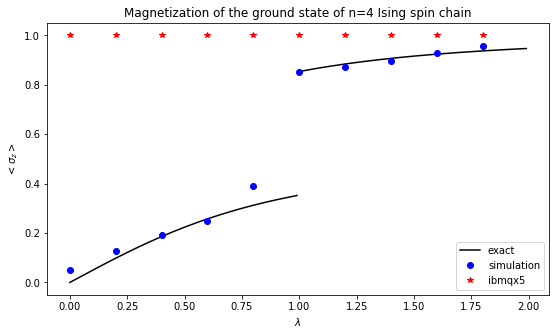

In [11]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la
def exact(lam):
    if lam <1:
        return lam/(2*np.sqrt(1+lam**2))
    if lam >1:
        return 1/2+lam/(2*np.sqrt(1+lam**2))
    return None
vexact = np.vectorize(exact)
l=np.arange(0.0,2.0,0.01)
l1=np.arange(0.0,2.0,0.2)
plt.figure(figsize=(9,5))
plt.plot(l,vexact(l),'k',label='exact')
plt.plot(l1, mag_sim, 'bo',label='simulation')
plt.plot(l1, mag, 'r*',label='ibmqx5')
plt.xlabel('$\lambda$')
plt.ylabel('$<\sigma_{z}>$')
plt.legend()
plt.title('Magnetization of the ground state of n=4 Ising spin chain')
plt.show()
